In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import UnaryLinear
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def linear_test(rng="Sobol", in_feature=128, out_feature=10000, bitwidth=8, bias=True):
    modes = ["bipolar", "unipolar"]
    bstype = torch.float
    buftype = torch.float
    randtype = torch.float
    scaled = [True, False]
    result_pe = []
    
    for mode in modes:
        for scale in scaled:
            length = 2**bitwidth
            result_pe_cycle = []
            fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
            
            if mode is "unipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(length).round().div(length).to(device)
            elif mode is "bipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(2).sub(1).mul(length).round().div(length).to(device)

            ufc = UnaryLinear(in_feature, out_feature, fc.weight, fc.bias, 
                              bitwidth=bitwidth, mode=mode, scaled=scale, bias=bias, 
                              bstype=bstype, buftype=buftype, randtype=randtype).to(device)

            iVec = ((torch.rand(1, in_feature)*length).round()/length).to(device)
            oVec = fc(iVec)

            iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, randtype=randtype)().to(device)
            iVecRNG = RNG(bitwidth, 1, rng, randtype=randtype)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, bstype=bstype).to(device)

            iVecPE = ProgressiveError(iVec, mode=mode).to(device)
            
            if scale is True:
                if bias == 0:
                    oVecPE = ProgressiveError(oVec, scale=in_feature, mode=mode).to(device)
                elif bias ==1:
                    oVecPE = ProgressiveError(oVec, scale=in_feature+1, mode=mode).to(device)
            else:
                oVecPE = ProgressiveError(oVec, scale=1, mode=mode).to(device)
            
            with torch.no_grad():
                idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                start_time = time.time()
                for i in range(length):
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)

                    oVecU = ufc(iBS)
                    oVecPE.Monitor(oVecU)
                    if bias is False:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                    else:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/(out_feature+1)).item())
                print("--- %s seconds ---" % (time.time() - start_time))
                print("input error: ", "min:", torch.min(iVecPE()[1]).item(), "max:", torch.max(iVecPE()[1]).item())
                print("output error: ", "min:", torch.min(oVecPE()[1]).item(), "max:", torch.max(oVecPE()[1]).item(), "RMSE: ", torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                result_pe = oVecPE()[1][0].cpu().numpy()
                print("error distribution=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                print("progressive accuracy=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.plot(result_pe_cycle)  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                

--- 0.866999626159668 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010694030672311783 max: -0.0017869737930595875 RMSE:  0.0066583408042788506
error distribution=========>


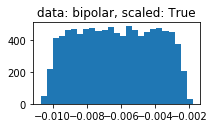

progressive accuracy=========>


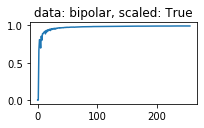

--- 0.8480005264282227 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.3486328125 max: 0.1328125 RMSE:  0.32373708486557007
error distribution=========>


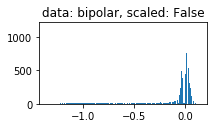

progressive accuracy=========>


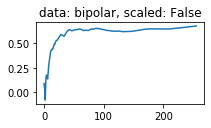

--- 0.5789999961853027 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.005515351891517639 max: -0.0012171119451522827 RMSE:  0.003538150107488036
error distribution=========>


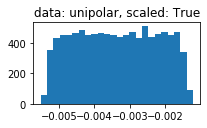

progressive accuracy=========>


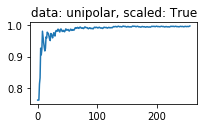

--- 0.5480015277862549 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


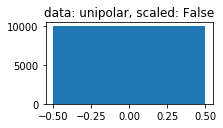

progressive accuracy=========>


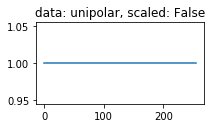

In [5]:
rng = "Sobol"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 0.8700003623962402 seconds ---
input error:  min: -0.01171875 max: 0.00390625
output error:  min: -0.010774757713079453 max: -0.0013018455356359482 RMSE:  0.006327877752482891
error distribution=========>


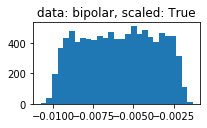

progressive accuracy=========>


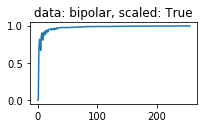

--- 0.8359999656677246 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.4214324951171875 max: 0.5234375 RMSE:  0.3236549496650696
error distribution=========>


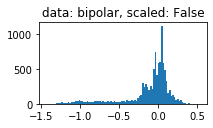

progressive accuracy=========>


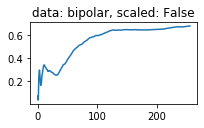

--- 0.5350005626678467 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.007530570030212402 max: -0.0032255947589874268 RMSE:  0.005476668477058411
error distribution=========>


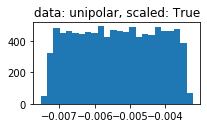

progressive accuracy=========>


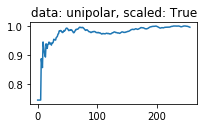

--- 0.5530006885528564 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


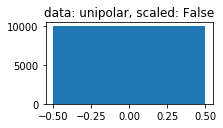

progressive accuracy=========>


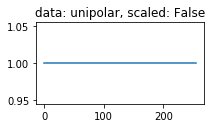

In [6]:
rng = "LFSR"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 0.7480015754699707 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010971485637128353 max: -0.0016412567347288132 RMSE:  0.0066568488255143166
error distribution=========>


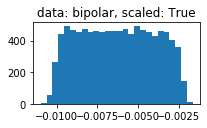

progressive accuracy=========>


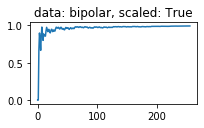

--- 0.7370004653930664 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.8671875 max: 1.671875 RMSE:  0.5627809166908264
error distribution=========>


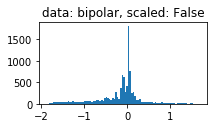

progressive accuracy=========>


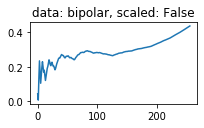

--- 0.5020003318786621 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.005631119012832642 max: -0.001322329044342041 RMSE:  0.0036218445748090744
error distribution=========>


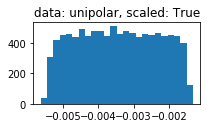

progressive accuracy=========>


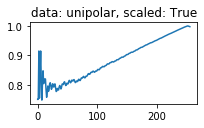

--- 0.5050005912780762 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


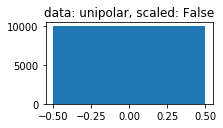

progressive accuracy=========>


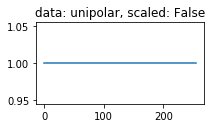

In [7]:
rng = "Race"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 0.8469996452331543 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010368896648287773 max: -0.0010739751160144806 RMSE:  0.006146131549030542
error distribution=========>


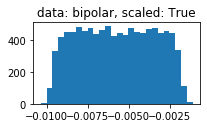

progressive accuracy=========>


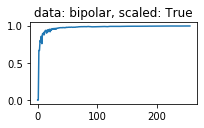

--- 0.8350005149841309 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.3359375 max: 0.40625 RMSE:  0.32073497772216797
error distribution=========>


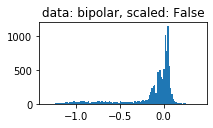

progressive accuracy=========>


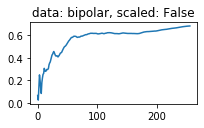

--- 0.5349979400634766 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.0056113749742507935 max: -0.0012822449207305908 RMSE:  0.003645912976935506
error distribution=========>


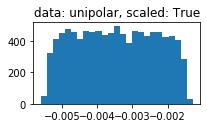

progressive accuracy=========>


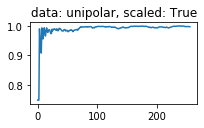

--- 0.5430014133453369 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


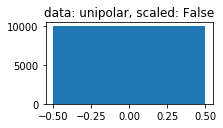

progressive accuracy=========>


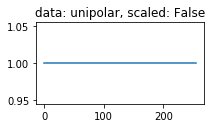

In [8]:
rng = "SYS"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)